Image credit: European Union, [Economies of scope in the aggregation of health-related data](https://joint-research-centre.ec.europa.eu/system/files/2021-09/jrc125767.pdf), under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

Python source: [451-blog/logreg.py at main · doabell/451-blog](https://github.com/doabell/451-blog/blob/main/posts/logistic-regression/logreg.py)

Instructions can be found at [Optimization for Logistic Regression](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-optimization.html).

In [1]:
# make life easier
# https://stackoverflow.com/a/5399339
%load_ext autoreload
%autoreload 2

## Comparing gradient descents
The [Python source file](https://github.com/doabell/451-blog/blob/main/posts/logistic-regression/logreg.py) implements three types of logistic regression with gradient descent:
- Batch gradient descent, updating the gradient all at once;
- Stochastic (minibatch) gradient descent, updating the gradient on random subsets;
- Stochastic (minibatch) gradient descent with momentum method.

### Note on terminology
I checked Google for a reasonable `batch_size` for this blog post's "stochastic gradient descent", and was unable to find one.

From [this Towards Data Science blog post](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a), it seems that "stochastic gradient descent" refers to an *online* method that checks one data point at a time.
A more common name for the method implemented in `LR.fit_stochastic()` is "minibatch" gradient descent, which strikes a balance between stochastic (one at a time) and "batch" (`LR.fit()`) gradient descent (all the data points, all at once).

### Batch gradient descent
With terminology out of the way, let us first prepare the data.

We generate data points with 2 features and 2 labels that are not linearly separable, as seen below:

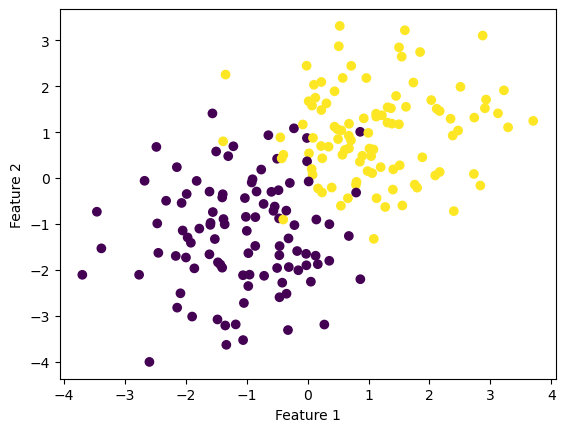

In [2]:
# Data
from logreg import LogisticRegression
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
np.seterr(all='ignore')
np.random.seed(283)

# make the data
p_features = 3
X, y = make_blobs(
    n_samples=200, n_features=p_features - 1, centers=[(-1, -1), (1, 1)]
)

fig = plt.scatter(X[:, 0], X[:, 1], c=y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


We can then fit our logistic regression with *batch gradient descent* as follows:

array([1.55018182, 1.56862046, 0.93683842])

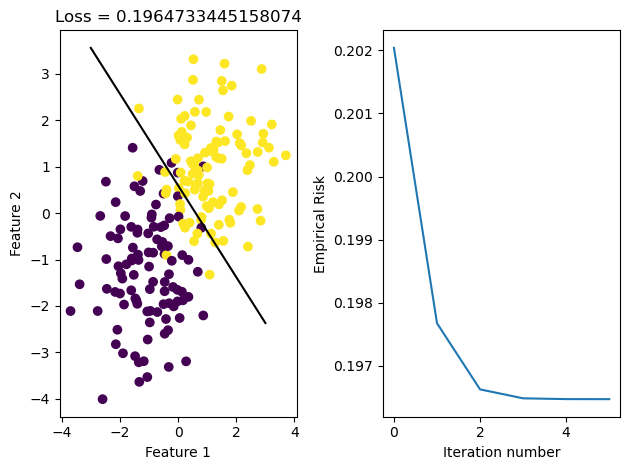

In [3]:
LR_batch = LogisticRegression()
LR_batch.fit(X, y, alpha=0.1, max_epochs=1000)

fig, axarr = plt.subplots(1, 2)

axarr[0].scatter(X[:, 0], X[:, 1], c=y)
axarr[0].set(
    xlabel="Feature 1", ylabel="Feature 2",
    title=f"Loss = {LR_batch.loss_history[-1]}"
)

f1 = np.linspace(-3, 3, 101)

p = axarr[0].plot(f1, (LR_batch.w[2] - f1*LR_batch.w[0])/LR_batch.w[1], color="black")

axarr[1].plot(LR_batch.loss_history)
axarr[1].set(xlabel="Iteration number", ylabel="Empirical Risk")
plt.tight_layout()


# inspect the fitted value of w
LR_batch.w


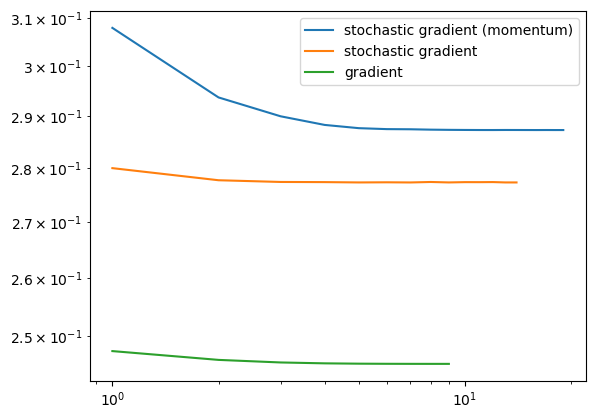

In [4]:
LR = LogisticRegression()
LR.fit_stochastic(
    X, y,
    max_epochs=1000,
    momentum=True,
    batch_size=10,
    alpha=.05
)

num_steps = len(LR.loss_history)
plt.plot(
    np.arange(num_steps) + 1, LR.loss_history,
    label="stochastic gradient (momentum)"
)

LR = LogisticRegression()
LR.fit_stochastic(
    X, y,
    max_epochs=1000,
    momentum=False,
    batch_size=10,
    alpha=.1
)

num_steps = len(LR.loss_history)
plt.plot(
    np.arange(num_steps) + 1, LR.loss_history,
    label="stochastic gradient"
)

LR = LogisticRegression()
LR.fit(X, y, alpha=.05, max_epochs=1000)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label="gradient")

plt.loglog()

legend = plt.legend()
